In [1]:
import re
import string
from typing import List
from copy import deepcopy
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import spacy
from nltk.corpus import stopwords
from nltk import tokenize

import torch
from torch import nn, optim
from torch.nn.utils.rnn import PackedSequence
from torch.utils.data import DataLoader, Dataset

from torchtext.vocab import build_vocab_from_iterator

from tqdm import tqdm

%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings("ignore")

# EDA

## Loading datasets

In [3]:
uk_geo_dataset = pd.read_csv('datasets/uk_geo_dataset.csv', converters={"loc_markers": eval})
ru_geo_dataset = pd.read_csv('datasets/ru_geo_dataset.csv', converters={"loc_markers": eval})
uk_geo_dataset.shape, ru_geo_dataset.shape

((1010000, 5), (8028840, 6))

## Examine the dataset for the presence of strange symbols

### First function to clean text

In [4]:
def preprocess_text(text):
    # Remove links
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Special remove telegram links
    pattern = r"(?:https?:\/\/)?(?:www\.)?(?:t\.me\/\S+|telegram\.me\/\S+|telegram\.dog\/\S+)"
    text = re.sub(pattern, '', text)

    # Remove phone numbers
    phone_regex = r'\(?\+?\d{0,3}\)?[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{2}[-.\s]?\d{2}'
    text = re.sub(phone_regex, '', text)

    # Remove special characters
    text = re.sub(r'[\n\t\r]', ' ', text)

    # Remove tags
    text = re.sub(r'@\w+', '', text)

    # Remove emojis
    emoji_pattern = re.compile(
        pattern="["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)

    # Remove multiple spaces
    text = re.sub(r' +', ' ', text)

    return text

Next we will search for non ASCII symbols that may be found in the text even after processing it with `preprocess_text`

In [5]:
def find_non_alphanumeric(text):
    # extracting all that not words
    pattern = re.compile(r'[^\w\s.,\-()]', re.UNICODE)
    matches = pattern.findall(text)
    return matches

Extracting non ASCII symbols from `uk_geo_dataset` texts.

In [6]:
uk_text_non_symbols = set()
for text in tqdm(uk_geo_dataset['text']):
    uk_text_non_symbols = uk_text_non_symbols | set(find_non_alphanumeric(preprocess_text(text)))

''.join(uk_text_non_symbols)

100%|██████████| 1010000/1010000 [00:22<00:00, 45285.00it/s]


'!¬*¨\u202d\u202c˗⃣¸§‰‐≤ְ⏺―\'«⏰‛<€"®—″−¤†”‒‘̶℃£•™“+·᾿:≈′`~∙‼?˚\u200f⎯°ֹ₴±–̆¡¦̈\u202a>҆́՚×´’„\u200b;∞%/»…̂‚≥&$№⋅→›‑'

Extracting non ASCII symbols from `ru_geo_dataset` texts.

In [7]:
ru_text_non_symbols = set()
for text in tqdm(ru_geo_dataset['text']):
    ru_text_non_symbols = ru_text_non_symbols | set(find_non_alphanumeric(preprocess_text(text)))

''.join(ru_text_non_symbols)

100%|██████████| 8028840/8028840 [03:22<00:00, 39648.83it/s]


'!¬*็ु{\u202cⒻ\u202d]\x0f∆‐←@،๊≡√\x04ा®—″†”‒\xad‘£™“\u2060+·:\u200c′‼˚\u200f¿°\x96ึ́×|้⏳̧∞⁾⁉ุ%/©ั\\^\x97#↓↑$№Ⓑ→\x98‑ો\x01⊕⃣¯\x03≠¸⁽؛ี≤ા―₽\'ู÷\x9d«¥<̀€"[−่※•ื\x08;Ⓔ؟`~∙?±–̆¡̈\u202a>ิ્´’∩„\u200b;»…\x7f‚&}'

In [8]:
text_non_symbols = uk_text_non_symbols | ru_text_non_symbols
''.join(text_non_symbols)

'!¬*¨\u202d็\u202cु{Ⓕ]\x0f§∆‐←@،ְ๊≡√\x04⏰ा®—″†”‒‘\xad̶£™“\u2060+·:≈\u200c′‼˚\u200f¿°\x96ึ́՚×|้⏳̧∞⁾⁉ุ%/©ั\\^\x97#≥↓↑$№Ⓑ⋅→\x98‑ો\x01⊕˗⃣¯\x03≠¸‰⁽؛ี≤ા⏺―₽\'ู÷\x9d«‛¥<̀€"¤−[่※℃•ื\x08;᾿Ⓔ؟`~∙?⎯ֹ₴±–̆¡¦̈\u202a>҆ิ્´’∩„\u200b;»…\x7f̂‚&}›'

### Second function to clean data

Next we will use base function from LB metric computation and see what non ASCII symbols this function leave

In [9]:
def hard_processing(text):
    text = re.sub(r"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\b\w\b\s?', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

In [10]:
uk_text_non_symbols = set()
for text in tqdm(uk_geo_dataset['text']):
    uk_text_non_symbols = uk_text_non_symbols | set(find_non_alphanumeric(hard_processing(text)))

''.join(uk_text_non_symbols)

100%|██████████| 1010000/1010000 [00:11<00:00, 91474.88it/s]


'!¬✊*¨\u202d\u202c✨§│‐\uf06e╓ְ❌⛔⏰☮®—″◈\uf0fc†”️‒‘̶♀£™\uf02d“+❤·⚪:≈′̇‼♦˚\ue06e￼➡\u200f°⬇́՚×（▶∞%/☀⠀\uf701╖≥$№⋅→‑⚖✈˗⃣\ue56b⚫¸\u200d‰╢≤╤☣⏺⚡―\'☝▪«‛<€\uf0a7"¤−℃•❓᾿\ufeff`~∙❗?⎯ֹ₴±–̆¡─¦̈\u202a✔>҆⚠✅´’„\u200b;»…\ue02d̂╥‚&♂›'

In [12]:
ru_text_non_symbols = set()
for text in tqdm(ru_geo_dataset['text']):
    ru_text_non_symbols = ru_text_non_symbols | set(find_non_alphanumeric(hard_processing(text)))

''.join(ru_text_non_symbols)

100%|██████████| 8028840/8028840 [02:01<00:00, 66279.59it/s]


'👨📷✊♏💅🐰🦋😳🤫∆🏻ⓑ👙🏼🙋❌🌙🛒☔🌿💡🍅🎇️♓🙃🛁♀£😜💉🚼⛰+🌅💚🔥:̇💪˚👣🇸🤯🎊🌏🎵🍉\uf0e8🍆🍴🍍😽∞☀♑👀🦍\x98🐊💩🐾🚿►✈✒🐒¯\x03⚫≠😆\u200d\uf60e﹏🍮🙆👞🖕🌞🔴💕―🇹\'「🎙🌳▪🌷÷💔😨💊🤩\x9d👻🇭🔵\uf0ff※❄🎅😼;`🐱💦◕∙🐼📻🙌̆🤭>🥇🐢🚲」્´👋∩🇨🥈🌌…\x7f🎉🦈😰😂📲🇮‚&👒♂ⓡ🙇¬*🌈ु🏊✨ⓝ🚗🇿😥@🍕💣💐☁。☑📆👓๊🌾ⓢ💭💗✌😡🛵👅″😫”😃\xad🐖™🌎😝♡❤⚪👌😁\u200c🍒🇰🏝￼\u200f🎪👯🚨🌵🏄📿́🤦💜😍|🗣⏳🤲̧🎆⁉ุ🔑💧ั/💸🍜©^☺🌥#😩\x01💰🚬🍁・🐴؛🎶🤵🤼🐺😶🎃≤\ue512⭐💍👽🌊🚀₽👩☇♛🚽«🔻¥🏿🇽🎤"🍾💿−📖่\U000fe327🐻👗🙈♉🤟🏾🏃؟🦄❗?⭕🌺👎🔊🐶💘–🐣¡─⚜\u202a〜🚺😑🇦„😛🎂🚢😀🌠🐓🤘🎥🌍!🙏♈🐬ⓣ]😮🇯🏂👆♪\x0f🎭😈‐🌕💎◠🎨🔜\U000fe512🤗🦀≡💋🐽🌼\x04🤤ा💙—†‒🍩🚂？👍🍪🌴🏽😖🤢😘♝🍬⚓🍿📺¿°🏆🏒📣👶😬⚽×⚔🚑🍔💓👼้⬅😢💀⁾🍫%👇⠀$№😌‑🐇🌟🌹🖤🙉⊕🥰♌⃣♜¸⁽🍼🚩🚫🧐☠🖖ા🍑🌩👏🔪ู☘🎁🎀😐🍹！<🤣€💇😴🏌🐚ื🇺👿❣🙀\ufeff😉😋🇲♥🐳🙄😒✴🥋☄✔♐’;🇱👉💟»😅👸♞💁👊🇪\uf0fe🤔ⓔ็\u202d\u202c〰✵🐔🇳\uf0eb📸🦁🏳←،😸🤠🔫🤙🐅🇷√🌝😓😻🎄🦊🎈🐠®📍‘🎬♚🗼“\u2060🤪·💥🔌🎼′‼🦅➡🕊⬆🕺\x96🎩👠ึ🔸🌧🇩🙊💖🍦\\😎\x97👈⚰↓↑🕶ⓕ→😊😏ો💫☎🐈😱🏨🤷👮👰ⓞ💃ี🍟🌸⚡💞☝💄🏺̀🤞[💝🤨•\x08😯🍀😦🐍🍓💌~🔨🔝🇵😇🥊±̈、👧🙅😹🏋ิ🐿\u200b😭😄💛👑✿🏔💯☕👟'

In [13]:
text_non_symbols = uk_text_non_symbols | ru_text_non_symbols
''.join(text_non_symbols)

'👨✊📷♏💅🐰🦋😳🤫∆🏻ⓑ👙🏼🙋❌🌙🛒☔🌿💡🍅🎇️♓🙃🛁♀£😜💉🚼⛰+🌅💚🔥:̇💪˚👣🇸🤯🎊🌏🎵🍉\uf0e8🍆🍴🍍▶😽∞☀♑👀🦍\x98🐊💩🐾🚿►✈✒🐒¯\ue56b⚫\x03≠😆\u200d\uf60e﹏🍮🙆👞🖕🌞🔴💕―🇹\'「🎙🌳▪🌷÷💔😨💊🤩\x9d👻🇭🔵\uf0ff※❄🎅😼;`🐱💦∙◕🐼⎯📻ֹ🙌̆🤭>🥇🐢🚲」્✅´👋∩🇨🥈🌌…\x7f🎉🦈😰😂📲🇮‚&👒♂ⓡ🙇¬*🌈ु🏊✨ⓝ🚗🇿│😥@🍕💣💐☁。☑📆👓๊🌾ⓢ💭💗✌⏰😡🛵👅″😫”😃\xad🐖™🌎😝♡❤⚪👌😁\u200c🍒🇰🏝♦￼\u200f🎪👯🚨⬇🌵🏄📿́🤦💜😍|🗣⏳🤲̧🎆⁉ุ🔑💧ั/💸🍜©^☺🌥#⚖😩\x01💰🚬🍁˗・🐴؛🎶🤵🤼🐺😶🎃≤\ue512⭐💍👽⏺🌊🚀₽👩☇♛🚽«🔻¥🏿🇽🎤"🍾💿−📖่\U000fe327🐻👗🙈♉🤟🏾🏃؟🦄❗?⭕🌺👎🔊🐶💘–🐣¡─¦\u202a⚜҆〜⚠🚺😑🇦„😛🎂🚢😀🌠🐓🤘🎥🌍!¨🙏♈🐬ⓣ]😮🇯🏂👆♪§\x0f🎭😈‐🌕💎╓◠🎨🔜ְ\U000fe512🤗🦀≡💋🐽🌼\x04⛔🤤ा💙☮—\uf0fc†‒🍩🚂？👍🍪\uf02d🌴🏽😖🤢≈😘♝🍬⚓🍿\ue06e📺¿°🏆🏒📣👶😬՚×⚽⚔🚑🍔💓👼้⬅😢💀⁾🍫%👇⠀╖$№⋅😌‑🐇🌟🌹🖤🙉⊕🥰♌⃣♜¸‰⁽🍼╢🚩🚫🧐☣☠🖖ા🍑🌩👏🔪ู☘🎁‛🎀😐🍹！<🤣€\uf0a7💇😴¤🏌🐚ื❓🇺👿❣🙀\ufeff😉😋🇲♥🐳🙄😒✴🥋☄✔♐’;🇱👉💟»😅👸♞\ue02d💁👊╥🇪›\uf0fe🤔ⓔ็\u202d\u202c〰✵🐔🇳\uf0eb📸🦁🏳\uf06e←،😸🤠🔫🤙🐅🇷√🌝😓😻🎄🦊🎈🐠®◈📍‘̶🎬♚🗼“\u2060🤪·💥🔌🎼′‼🦅➡🕊⬆🕺\x96🎩👠ึ🔸🌧（🇩🙊💖🍦\\\uf701😎\x97👈⚰↓≥↑🕶ⓕ→😊😏ો💫☎🐈😱🏨🤷👮👰ⓞ💃ี╤🍟🌸⚡💞☝💄🏺̀🤞[💝℃🤨•\x08😯🍀᾿😦🐍🍓💌~🔨🔝🇵😇₴±🥊̈、👧🙅😹🏋ิ🐿\u200b😭😄💛👑✿🏔̂💯☕👟'

As we see original text preprocessing function leave a lot of emojis and other Unicode symbols. 
Due to the fact that train and test data not clean enough, I prefer to use this function to clean the data before training, but for real production it better to use first preprocessing function (`process_text`)

## Extracting location from texts

In this part we extract all location from both datasets and look what Unicode symbols we should additionally remove or how we can preprocess location markers.

In [14]:
def get_locations(row, with_text=False):
    text, locs = row[0], row[1]
    locs = [text[loc[0]:loc[1]] for loc in locs]
    return (text, locs) if with_text else locs

In [15]:
uklocs = uk_geo_dataset[['text', 'loc_markers']].apply(get_locations, axis=1)
uklocs = set(chain.from_iterable(uklocs.tolist()))
len(uklocs)

45430

In [16]:
rulocs = ru_geo_dataset[['text', 'loc_markers']].apply(get_locations, axis=1)
rulocs = set(chain.from_iterable(rulocs.tolist()))
len(rulocs)

132589

In [17]:
locs_non_symbols = set()
locs_with_non_symbols = []
for text in tqdm(list(uklocs | rulocs)):
    cur_symb = find_non_alphanumeric(preprocess_text(text))
    if cur_symb:
        locs_with_non_symbols.append(text)
    locs_non_symbols = locs_non_symbols | set(cur_symb)

''.join(locs_non_symbols)

100%|██████████| 174709/174709 [00:01<00:00, 165266.15it/s]


'“!¬+\u202d\u202c:]′`?\u200f‐–̆̈\u202a\'́|«’„\u200b;%/»…"\x7f—″[¤−”‘\xad#&№‑'

In [18]:
len(locs_with_non_symbols)

3244

In [19]:
import random

random.sample(locs_with_non_symbols, 10)

['Кам’янець-Подільську фортецю',
 'ТРЦ "Проспект"',
 'Невинномысского акционерного общества "Азот"',
 'Національному заповіднику “Херсонес Таврійський”',
 'вулиць «Льотчиків-Визволителів',
 'Придністорв’ї',
 'вул.…',
 'парк «',
 'Киев—Обухов',
 'Петропавлівський в’язниці']

## Preprocess our datasets

This function removes unopened or unclosed brackets

In [20]:
def remove_unbalanced_brackets(text):
    # Remove unopened or unclosed brackets
    while '(' in text and ')' not in text[text.index('('):]:
        text = text.replace('(', '', 1)
    while ')' in text and '(' not in text[:text.rindex(')')]:
        text = text[:text.rindex(')')] + text[text.rindex(')') + 1:]
    return text


Updated preprocessing function base on previous EDA.

In [21]:
def preprocess_text(text):
    # Your existing preprocessing steps
    text = re.sub(r'http\S+|www.\S+', '', text)
    phone_regex = r'\(?\+?\d{0,3}\)?[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{2}[-.\s]?\d{2}'
    text = re.sub(phone_regex, '', text)

    chars_to_remove = ('+;°#̂,ี¡”\x03ֹ≠้‑".‘ા·:⁉*->˗’√Ⓑ\u202c§ื}¿؛⏺≈̀|∩„\xad¸®¬ิ¦;“¥–€̆ึ⋅Ⓔ\u202d≥→←҆¯'
                       '⏳̶™…©»№\x9d℃\x96\x08?«็−ุ،‰~ู̧∆‼•\\^¨\u2060᾿ְ※<₽\x7f\u200f่[\x04]⃣\x0f\xa0'
                       '⏰\u200c%±″†(÷′Ⓕ́ु$՚`/\'∙{ा)₴£\u202aั⁾≡×&¤⊕↓⁽\x97̈؟\x98๊≤@↑˚ો્´!›‚∞‛\u200b\x01')
    text = re.sub('[' + re.escape(chars_to_remove) + ']', '', text)

    text = re.sub(r'[\n\t]', ' ', text)
    text = re.sub(r'@\w+', '', text)
    pattern = r"(?:https?:\/\/)?(?:www\.)?(?:t\.me\/\S+|telegram\.me\/\S+|telegram\.dog\/\S+)"
    text = re.sub(pattern, '', text)
    emoji_pattern = re.compile(
        pattern="["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r' +', ' ', text)
    text = remove_unbalanced_brackets(text)

    return text

Function to update location markers indices after texts and locations text were processed

In [22]:
def update_locations(row, text_processor):
    text, locations = row
    location_texts = get_locations((text, locations))
    text = text_processor(text)

    new_locations = []
    offset = 0
    for loc_text in location_texts:
        clean_loc_text = text_processor(loc_text)
        start_idx = text.find(clean_loc_text, offset)
        if start_idx != -1:
            end_idx = start_idx + len(clean_loc_text)
            new_locations.append((start_idx, end_idx))
            offset = end_idx

    return text, new_locations

Finally, this function clean texts and locations text with `text_processor`, than it merge some locations that was splitted, like ['Івано', '-Франківськ'], or delete unuseful dots and dashes.

In [23]:
def clean_text_and_locations(row, text_processor=preprocess_text):
    index = 0
    text, locations = update_locations(row, text_processor)
    result: list[tuple[int, int]] = []

    while True:
        if index >= len(locations):
            break

        location = locations[index]
        location_text = text[location[0]:location[1]]
        try:
            if location_text.startswith('-'):
                if len(location_text) > 1:
                    result[-1] = (result[-1][0], location[1])
                else:
                    result[-1] = (result[-1][0], locations[index + 1][1])
                    index += 1
            elif location_text.endswith(('.', '. ', '—', '— ')):
                if location_text != '.' and location_text != 'вул.':
                    new_end = location_text.rfind('.')
                    new_end = len(location_text[:new_end].strip())
                    result.append((location[0], location[0] + new_end))
            elif ' і ' in location_text:
                loc1, loc2 = location_text.split(' і ')
                result.extend(
                    [
                        (location[0], location[0] + len(loc1)),
                        (location[1] - len(loc2), location[1])
                    ]
                )
            else:
                result.append(location)
        except Exception:
            pass

        index += 1
    return text, result

### Process uk dataset

Now we use all previous functions to make 'light' clean pair (`text`, `loc_marker`) and 'hard' clea pair for both `uk_geo_dataset`

In [24]:
cleaned_uk = uk_geo_dataset[['text', 'loc_markers']].apply(clean_text_and_locations, axis=1)
cleaned_uk = list(zip(*cleaned_uk))
cleaned_uk = pd.DataFrame({'clean_text': cleaned_uk[0], 'clean_loc_markers': cleaned_uk[1]})
cleaned_uk.shape

(1010000, 2)

In [25]:
hard_cleaned_uk = uk_geo_dataset[['text', 'loc_markers']].apply(
    clean_text_and_locations, axis=1, args=(hard_processing,)
)
hard_cleaned_uk = list(zip(*hard_cleaned_uk))
hard_cleaned_uk = pd.DataFrame({'hard_clean_text': hard_cleaned_uk[0], 'hard_clean_loc_markers': hard_cleaned_uk[1]})
hard_cleaned_uk.shape

(1010000, 2)

In [26]:
uk_geo_df = pd.concat([uk_geo_dataset, cleaned_uk, hard_cleaned_uk], axis=1)
uk_geo_df.head()

,text,loc_markers,org_markers,per_markers,is_valid,clean_text,clean_loc_markers,hard_clean_text,hard_clean_loc_markers
0,"Чим довше мають скачки тиску гіпертензією, тим...",[],[],[],0,Чим довше мають скачки тиску гіпертензією тим ...,[],"чим довше мають скачки тиску гіпертензією, тим...",[]
1,"А поки що починали цвісти троянди, випускники ...",[],[],"[(114, 131)]",0,А поки що починали цвісти троянди випускники с...,[],"поки що починали цвісти троянди, випускники ск...",[]
2,"Крім того, в 2020 р. багато експертів прогнозу...",[],[],[],0,Крім того в 2020 р багато експертів прогнозуют...,[],"крім того, багато експертів прогнозують виникн...",[]
3,"Сильно сумніваюся, що ви зупините свій вибір н...",[],[],[],0,Сильно сумніваюся що ви зупините свій вибір на...,[],"сильно сумніваюся, що ви зупините свій вибір н...",[]
4,Цей унікальний правовий важіль утворено 1998 р...,[],[],[],0,Цей унікальний правовий важіль утворено 1998 р...,[],цей унікальний правовий важіль утворено року д...,[]


Comparing the preprocessing of `uk_geo_dataset`

In [27]:
uk_locations = pd.DataFrame(
    {
        'locs': uk_geo_df[uk_geo_df['loc_markers'].apply(lambda x: len(x) > 0)][['text', 'loc_markers']].apply(
            get_locations, axis=1
            ),
        'clean_locs': uk_geo_df[uk_geo_df['loc_markers'].apply(lambda x: len(x) > 0)][
            ['clean_text', 'clean_loc_markers']].apply(get_locations, axis=1),
        'hard_clean_locs': uk_geo_df[uk_geo_df['loc_markers'].apply(lambda x: len(x) > 0)][
            ['hard_clean_text', 'hard_clean_loc_markers']].apply(get_locations, axis=1),
    }
)
uk_locations.head(20)

,locs,clean_locs,hard_clean_locs
13,[Великій Британії],[Великій Британії],[великій британії]
16,"[Львові, Яворівського району]","[Львові, Яворівського раиону]","[львові, яворівського району]"
21,[України],[України],[україни]
23,"[України, Білорусі]","[України, Білорусі]","[україни, білорусі]"
25,[України],[України],[україни]
42,[Білорусі],[Білорусі],[білорусі]
48,"[Крихівців, Опришівців]","[Крихівців, Опришівців]","[крихівців, опришівців]"
52,[Дніпра],[Дніпра],[дніпра]
55,[Рівненщини],[Рівненщини],[рівненщини]
70,[Донецька],[Донецька],[донецька]


In [28]:
uk_locations.sample(10)

,locs,clean_locs,hard_clean_locs
247889,[Китаю],[Китаю],[китаю]
675210,[Москви],[Москви],[москви]
387367,[Сході України],[Сході України],[сході україни]
20587,[Україну],[Україну],[україну]
989670,"[США, Вашингтон]","[США, Вашингтон]","[сша, вашингтон]"
656940,[Карпати],[Карпати],[карпати]
329242,"[Калуші, площі Героїв]","[Калуші, площі Героїв]","[калуші, площі героїв]"
346455,"[Британії, Північної Ірландії, Букінгемського ...","[Британії, Північної Ірландії, Букінгемського ...","[британії, північної ірландії, букінгемського ..."
333341,[Україні],[Україні],[україні]
505026,"[Росії, Російській Федерації]","[Росії, Російській Федерації]","[росії, російській федерації]"


### Process ru dataset

Next, we use all previous functions to make 'light' clean pair (`text`, `loc_marker`) and 'hard' clea pair for both `ru_geo_dataset`

In [29]:
cleaned_ru = ru_geo_dataset[['text', 'loc_markers']].apply(clean_text_and_locations, axis=1)
cleaned_ru = list(zip(*cleaned_ru))
cleaned_ru = pd.DataFrame({'clean_text': cleaned_ru[0], 'clean_loc_markers': cleaned_ru[1]})
cleaned_ru.shape

(8028840, 2)

In [30]:
hard_cleaned_ru = ru_geo_dataset[['text', 'loc_markers']].apply(
    clean_text_and_locations, axis=1,
    args=(hard_processing,)
    )
hard_cleaned_ru = list(zip(*hard_cleaned_ru))
hard_cleaned_ru = pd.DataFrame({'hard_clean_text': hard_cleaned_ru[0], 'hard_clean_loc_markers': hard_cleaned_ru[1]})
hard_cleaned_ru.shape

(8028840, 2)

In [31]:
ru_geo_df = pd.concat([ru_geo_dataset, cleaned_ru, hard_cleaned_ru], axis=1)
ru_geo_df.head()

,text,loc_markers,org_markers,per_markers,doc_id,sent_id,clean_text,clean_loc_markers,hard_clean_text,hard_clean_loc_markers
0,Вице-премьер по социальным вопросам Татьяна Го...,"[(82, 88)]","[(149, 160)]","[(36, 52)]",0,0,Вицепремьер по социальным вопросам Татьяна Гол...,"[(80, 86)]",вице-премьер по социальным вопросам татьяна го...,"[(80, 86)]"
1,"По словам Голиковой, чаще всего онкологические...","[(89, 98), (100, 108), (110, 118), (121, 139),...",[],"[(10, 19)]",0,1,По словам Голиковой чаще всего онкологические ...,"[(88, 97), (98, 106), (107, 115), (118, 136), ...","по словам голиковой, чаще всего онкологические...","[(87, 96), (98, 106), (108, 116), (117, 135), ..."
2,"Вице-премьер напомнила, что главные факторы см...","[(57, 63)]",[],[],0,2,Вицепремьер напомнила что главные факторы смер...,"[(55, 61)]","вице-премьер напомнила, что главные факторы см...","[(55, 61)]"
3,"В начале года стало известно, что смертность о...",[],[],[],0,3,В начале года стало известно что смертность от...,[],"начале года стало известно, что смертность от ...",[]
4,"По данным Росстата, в 2017 году от рака умерли...",[],"[(10, 18)]",[],0,4,По данным Росстата в 2017 году от рака умерли ...,[],"по данным росстата, году от рака умерли тысяч ...",[]


Comparing the preprocessing of `uk_geo_dataset`

In [32]:
ru_locations = pd.DataFrame(
    {
        'locs': ru_geo_df[ru_geo_df['loc_markers'].apply(lambda x: len(x) > 0)][['text', 'loc_markers']].apply(
            get_locations, axis=1
        ),
        'clean_locs': ru_geo_df[ru_geo_df['loc_markers'].apply(lambda x: len(x) > 0)][
            ['clean_text', 'clean_loc_markers']].apply(get_locations, axis=1),
        'hard_clean_locs': ru_geo_df[ru_geo_df['loc_markers'].apply(lambda x: len(x) > 0)][
            ['hard_clean_text', 'hard_clean_loc_markers']].apply(get_locations, axis=1),
    }
)
ru_locations.head(20)

,locs,clean_locs,hard_clean_locs
0,[России],[России],[россии]
1,"[Псковской, Тверской, Тульской, Орловской обла...","[Псковской, Тверской, Тульской, Орловской обла...","[псковской, тверской, тульской, орловской обла..."
2,[России],[России],[россии]
6,[Австрийские],[Австрийские],[австрийские]
7,"[России, Вене]","[России, Вене]","[россии, вене]"
12,"[России, Хохфильцене]","[России, Хохфильцене]","[россии, хохфильцене]"
14,[Обертиллахе],[Обертиллахе],[обертиллахе]
16,[Австрии],[Австрии],[австрии]
20,"[Диснейленд, Токио, Диснейленда]","[Диснейленд, Токио, Диснейленда]","[диснейленд, токио, диснейленда]"
25,[Исландия],[Исландия],[исландия]


In [33]:
ru_locations.sample(10)

,locs,clean_locs,hard_clean_locs
6050538,[Гусева],[Гусева],[гусева]
5894143,[Туркмении],[Туркмении],[туркмении]
7064432,[США],[США],[сша]
7267665,[России],[России],[россии]
1556632,[Украины],[Украины],[украины]
513079,[Сирии],[Сирии],[сирии]
3573462,"[Айхберг, Eichberg]","[Айхберг, Eichberg]","[айхберг, ehb]"
6533715,[Иран],[Иран],[иран]
2379005,[Китае],[Китае],[китае]
3847692,[Центрального административного округа],[Центрального административного округа],[центрального административного округа]


## Look for distributions of number of locations and text lenghths 

In [34]:
uk_geo_df['number_of_locations'] = uk_geo_df['clean_loc_markers'].apply(len)
ru_geo_df['number_of_locations'] = ru_geo_df['clean_loc_markers'].apply(len)

As in lecture we make `stratify_col`, to split our datasets in future

In [35]:
uk_geo_df["stratify_col"] = uk_geo_df["number_of_locations"]
uk_geo_df.loc[uk_geo_df["number_of_locations"] >= 14, "stratify_col"] = -1

ru_geo_df["stratify_col"] = ru_geo_df["number_of_locations"]
ru_geo_df.loc[ru_geo_df["number_of_locations"] >= 14, "stratify_col"] = -1

<Axes: xlabel='stratify_col', ylabel='Count'>

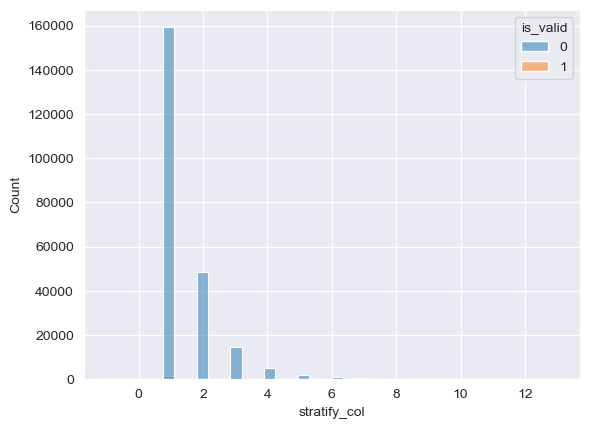

In [36]:
sns.histplot(uk_geo_df[uk_geo_df['number_of_locations'] > 0], x='stratify_col', hue='is_valid', bins=40)

<Axes: xlabel='stratify_col', ylabel='Count'>

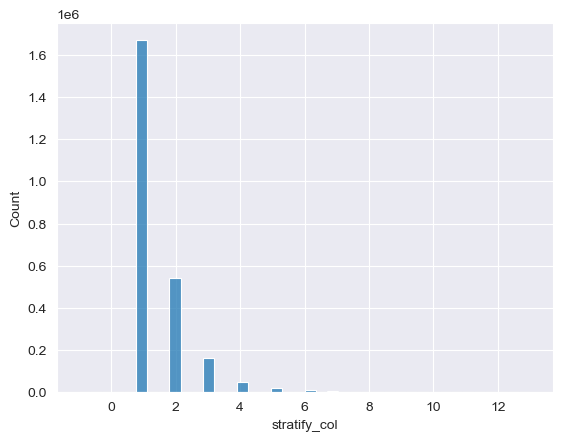

In [37]:
sns.histplot(ru_geo_df[ru_geo_df['number_of_locations'] > 0], x='stratify_col', bins=40)

As we above, `uk_geo_dataset` and `ru_geo_dataset` have the same distribution of number of location.

Next we will look for distribution of text lengths:

In [38]:
import spacy

tokenizer = spacy.load("xx_ent_wiki_sm", disable=["tagger", "parser", "ner", "textcat"])

<Axes: xlabel='hard_clean_text', ylabel='Count'>

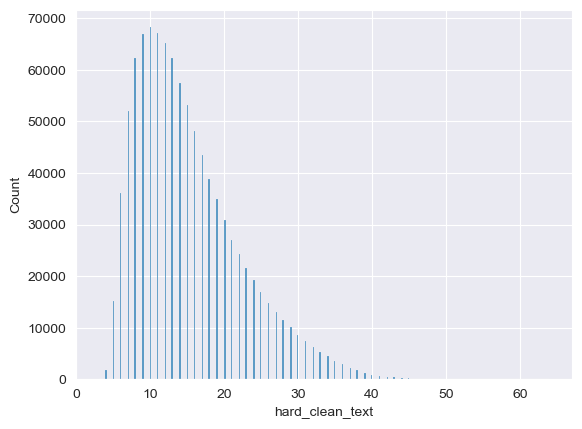

In [39]:
sns.histplot(uk_geo_df['hard_clean_text'].apply(lambda x: len(tokenizer(x))))

<Axes: xlabel='hard_clean_text', ylabel='Count'>

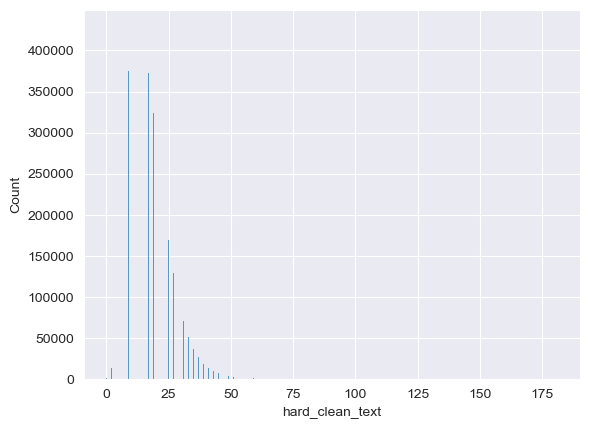

In [40]:
sns.histplot(ru_geo_df['hard_clean_text'].apply(lambda x: len(tokenizer(x))))

These distributions look similar, but in `ru_geo_df` more gaps in distribution.
Also, we can see, that in `ru_geo_df` there are some outliers in data (too long sentences), thats why I decided to remove them:

In [44]:
too_long_indices = ru_geo_df['hard_clean_text'].apply(lambda x: len(tokenizer(x))) >= 100
ru_geo_df[too_long_indices].shape

(516, 12)

In [45]:
ru_geo_df = ru_geo_df[~too_long_indices].reset_index(drop=True)
ru_geo_df.shape

(8028324, 12)

Finally, we look at the distribution of text lengths in test dataset:

<Axes: xlabel='text', ylabel='Count'>

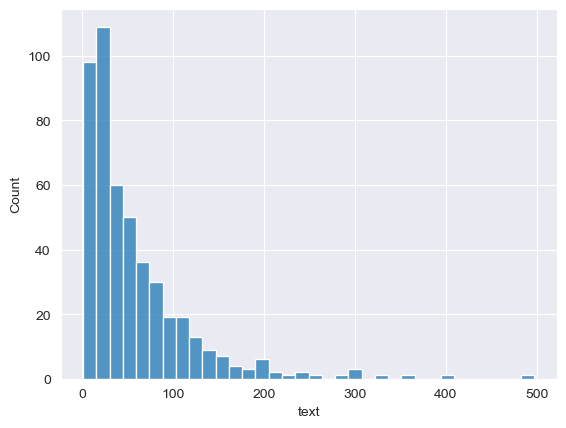

In [46]:
test = pd.read_csv('datasets/test.csv')
sns.histplot(test['text'].apply(lambda x: len(tokenizer(hard_processing(x)))))

## Concatenate the datasets
### Split `ru_geo_df` on train/test(valid) groups 

In [47]:
from sklearn.model_selection import train_test_split

ru_geo_df_train, ru_geo_df_test = train_test_split(
    ru_geo_df, test_size=uk_geo_df['is_valid'].sum() / uk_geo_df.shape[0], stratify=ru_geo_df[
        'stratify_col']
    )

ru_geo_df_train['is_valid'] = 0
ru_geo_df_test['is_valid'] = 1

ru_geo_df = pd.concat([ru_geo_df_train, ru_geo_df_test]).reset_index(drop=True)
ru_geo_df.head()

,text,loc_markers,org_markers,per_markers,doc_id,sent_id,clean_text,clean_loc_markers,hard_clean_text,hard_clean_loc_markers,number_of_locations,stratify_col,is_valid
0,Верховный суд США запретил психически больным ...,"[(14, 17)]","[(0, 13), (118, 137)]",[],505031,0,Верховный суд США запретил психически больным ...,"[(14, 17)]",верховный суд сша запретил психически больным ...,"[(14, 17)]",1,1,0
1,"«Может быть, на благотворительном концерте?",[],[],[],275352,2,Может быть на благотворительном концерте,[],"«может быть, на благотворительном концерте?",[],0,0,0
2,Задержанного уже этапировали в регион совершен...,"[(66, 72)]",[],[],293456,5,Задержанного уже этапировали в регион совершен...,"[(64, 70)]",задержанного уже этапировали регион совершения...,"[(62, 68)]",1,1,0
3,"В само жюри вошли известные журналисты, руково...",[],[],[],596815,3,В само жюри вошли известные журналисты руковод...,[],"само жюри вошли известные журналисты, руководи...",[],0,0,0
4,"В частности, ВВС страны используют боеприпасы ...",[],"[(13, 16)]",[],290177,6,В частности ВВС страны используют боеприпасы A...,[],"частности, ввс страны используют боеприпасы ai...",[],0,0,0


### Merging ru and ua datasets

In [48]:
uk_geo_df['language'] = 'ua'
ru_geo_df['language'] = 'ru'

df = pd.concat([uk_geo_df, ru_geo_df]).reset_index(drop=True)
df.head()

,text,loc_markers,org_markers,per_markers,is_valid,clean_text,clean_loc_markers,hard_clean_text,hard_clean_loc_markers,number_of_locations,stratify_col,language,doc_id,sent_id
0,"Чим довше мають скачки тиску гіпертензією, тим...",[],[],[],0,Чим довше мають скачки тиску гіпертензією тим ...,[],"чим довше мають скачки тиску гіпертензією, тим...",[],0,0,ua,NaN,NaN
1,"А поки що починали цвісти троянди, випускники ...",[],[],"[(114, 131)]",0,А поки що починали цвісти троянди випускники с...,[],"поки що починали цвісти троянди, випускники ск...",[],0,0,ua,NaN,NaN
2,"Крім того, в 2020 р. багато експертів прогнозу...",[],[],[],0,Крім того в 2020 р багато експертів прогнозуют...,[],"крім того, багато експертів прогнозують виникн...",[],0,0,ua,NaN,NaN
3,"Сильно сумніваюся, що ви зупините свій вибір н...",[],[],[],0,Сильно сумніваюся що ви зупините свій вибір на...,[],"сильно сумніваюся, що ви зупините свій вибір н...",[],0,0,ua,NaN,NaN
4,Цей унікальний правовий важіль утворено 1998 р...,[],[],[],0,Цей унікальний правовий важіль утворено 1998 р...,[],цей унікальний правовий важіль утворено року д...,[],0,0,ua,NaN,NaN


Delete all too short text:

In [49]:
df[(df['text'].apply(len) < 20) & (df['number_of_locations'] != 0)]

,text,loc_markers,org_markers,per_markers,is_valid,clean_text,clean_loc_markers,hard_clean_text,hard_clean_loc_markers,number_of_locations,stratify_col,language,doc_id,sent_id
1011061,"Андре Агасси, США8.","[(14, 17)]",[],"[(0, 12)]",0,Андре Агасси США8,"[(13, 16)]","андре агасси, сша","[(14, 17)]",1,1,ru,610608.0,53.0
1018100,Франция!,"[(0, 7)]",[],[],0,Франция,"[(0, 7)]",франция!,"[(0, 7)]",1,1,ru,75311.0,6.0
1018724,Лиссабон;,"[(0, 8)]",[],[],0,Лиссабон,"[(0, 8)]",лиссабон;,"[(0, 8)]",1,1,ru,518611.0,5.0
1038075,"""Почему Украина?","[(8, 15)]",[],[],0,Почему Украина,"[(7, 14)]","""почему украина?","[(8, 15)]",1,1,ru,303006.0,2.0
1047357,Народ Украины!,"[(6, 13)]",[],[],0,Народ Украины,"[(6, 13)]",народ украины!,"[(6, 13)]",1,1,ru,424143.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9022331,Хорватия - 11428.,"[(0, 8)]",[],[],1,Хорватия 11428,"[(0, 8)]",хорватия -,"[(0, 8)]",1,1,ru,478681.0,19.0
9025927,обсерватории Кек,"[(13, 16)]",[],[],1,обсерватории Кек,"[(13, 16)]",обсерватории кек,"[(13, 16)]",1,1,ru,633647.0,0.0
9032347,«Киев.,"[(1, 6)]",[],[],1,Киев,"[(0, 4)]",«киев,"[(1, 5)]",1,1,ru,72459.0,4.0
9036640,Германия – 13397.,"[(0, 8)]",[],[],1,Германия 13397,"[(0, 8)]",германия –,"[(0, 8)]",1,1,ru,570667.0,13.0


In [50]:
df = df[(df['text'].apply(len) >= 20)]
df.shape

(9008516, 14)

## Building subdatasets

In [51]:
_, small_df = train_test_split(df, test_size=1e5 / df.shape[0], stratify=df['is_valid'])
_, medium_df = train_test_split(df, test_size=1e6 / df.shape[0], stratify=df['is_valid'])

small_df = small_df.reset_index(drop=True)
medium_df = medium_df.reset_index(drop=True)

small_df.shape, medium_df.shape

((100000, 14), (1000000, 14))

In [52]:
small_df.to_csv('datasets/small_dataset.csv', index=False)
medium_df.to_csv('datasets/medium_dataset.csv', index=False)
df.to_csv('datasets/big_dataset.csv', index=False)

In [53]:
small_df[small_df['is_valid'] == 0].to_csv('datasets/small_train.csv', index=False)
small_df[small_df['is_valid'] == 1].to_csv('datasets/small_test.csv', index=False)

medium_df[medium_df['is_valid'] == 0].to_csv('datasets/medium_train.csv', index=False)
medium_df[medium_df['is_valid'] == 1].to_csv('datasets/medium_test.csv', index=False)

df[df['is_valid'] == 0].to_csv('datasets/big_train.csv', index=False)
df[df['is_valid'] == 1].to_csv('datasets/big_test.csv', index=False)

# Process based on `doc_id`

Firstly, we group our texts base on `doc_id`.

In [54]:
docs_groups = ru_geo_dataset.groupby('doc_id')

Next, this function either return only merged document text, or can do previous and shifted the location markers due to new location position.

In [55]:
def merge_groups(group, text_only=True):
    group = group.sort_values(by=['sent_id']).reset_index(drop=True)
    if text_only:
        return ' '.join(group['text'])
    else:
        try:
            offset = 0
            new_locs = group.loc[0, 'loc_markers']
            for sentence, locs in zip(group['text'].tolist()[:-1], group['loc_markers'].tolist()[1:]):
                offset += len(sentence)
                for loc in locs:
                    new_locs.append((loc[0]+  offset, loc[1] + offset))
        except Exception:
            print(group)
        return {'text': ' '.join(group['text']), 'loc_markers': new_locs}

In [56]:
grouped_ru_df = docs_groups.apply(merge_groups, text_only=False)
grouped_ru_df = pd.DataFrame({
    'text': [row['text'] for row in grouped_ru_df],
    'loc_markers': [row['loc_markers'] for row in grouped_ru_df]
})
grouped_ru_df

,text,loc_markers
0,Вице-премьер по социальным вопросам Татьяна Го...,"[(82, 88), (250, 259), (261, 269), (271, 279),..."
1,Австрийские правоохранительные органы не предс...,"[(0, 11), (147, 153), (156, 160), (580, 586), ..."
2,Сотрудники социальной сети Instagram проанализ...,"[(256, 266), (269, 274), (388, 399), (945, 953)]"
3,С начала расследования российского вмешательст...,"[(65, 68), (182, 185), (450, 453), (662, 665),..."
4,Хакерская группировка Anonymous опубликовала н...,"[(382, 396), (505, 510), (551, 572), (636, 641..."
...,...,...
739185,Сегодня областной центр Сахалина и Курил получ...,"[(24, 32), (35, 40), (148, 167), (192, 207), (..."
739186,Выступая сегодня на пресс-конференции в Москве...,"[(40, 46)]"
739187,Сегодня утром в районах дагестанских селений Ч...,"[(45, 54), (57, 65), (228, 230), (233, 242), (..."
739188,Намеченная на сегодняшний день церемония вступ...,"[(146, 152), (311, 317), (363, 381), (447, 465..."


## Preprocessing of documents text

The steps of text preprocessing absolutely similar to ones we done before

In [57]:
cleaned_ru = grouped_ru_df[['text', 'loc_markers']].apply(clean_text_and_locations, axis=1)
cleaned_ru = list(zip(*cleaned_ru))
cleaned_ru = pd.DataFrame({'clean_text': cleaned_ru[0], 'clean_loc_markers': cleaned_ru[1]})
cleaned_ru.shape

(739190, 2)

In [58]:
hard_cleaned_ru = grouped_ru_df[['text', 'loc_markers']].apply(
    clean_text_and_locations, axis=1,
    args=(hard_processing,)
)
hard_cleaned_ru = list(zip(*hard_cleaned_ru))
hard_cleaned_ru = pd.DataFrame({'hard_clean_text': hard_cleaned_ru[0], 'hard_clean_loc_markers': hard_cleaned_ru[1]})
hard_cleaned_ru.shape

(739190, 2)

In [59]:
ru_geo_docs_df = pd.concat([grouped_ru_df, cleaned_ru, hard_cleaned_ru], axis=1).reset_index(drop=True)
ru_geo_docs_df.head()

,text,loc_markers,clean_text,clean_loc_markers,hard_clean_text,hard_clean_loc_markers
0,Вице-премьер по социальным вопросам Татьяна Го...,"[(82, 88), (250, 259), (261, 269), (271, 279),...",Вицепремьер по социальным вопросам Татьяна Гол...,"[(80, 86), (245, 254), (255, 263), (264, 272),...",вице-премьер по социальным вопросам татьяна го...,"[(80, 86), (246, 254), (257, 264), (267, 274),..."
1,Австрийские правоохранительные органы не предс...,"[(0, 11), (147, 153), (156, 160), (580, 586), ...",Австрийские правоохранительные органы не предс...,"[(0, 11), (146, 152), (155, 159), (567, 573), ...",австрийские правоохранительные органы не предс...,"[(0, 11), (77, 82), (154, 157), (562, 567), (5..."
2,Сотрудники социальной сети Instagram проанализ...,"[(256, 266), (269, 274), (388, 399), (945, 953)]",Сотрудники социальной сети Instagram проанализ...,"[(252, 262), (265, 270), (383, 394), (924, 932)]",сотрудники социальной сети im проанализировали...,"[(226, 234), (237, 240), (349, 358), (855, 860)]"
3,С начала расследования российского вмешательст...,"[(65, 68), (182, 185), (450, 453), (662, 665),...",С начала расследования российского вмешательст...,"[(65, 68), (181, 184), (443, 446), (653, 656),...",начала расследования российского вмешательства...,"[(61, 64), (161, 163), (405, 408), (606, 609),..."
4,Хакерская группировка Anonymous опубликовала н...,"[(382, 396), (505, 510), (551, 572), (636, 641...",Хакерская группировка Anonymous опубликовала н...,"[(377, 391), (498, 503), (542, 563), (625, 630...",хакерская группировка aym опубликовала новые д...,"[(351, 363), (461, 463), (501, 520), (520, 520..."


## Processing outliers 

In [60]:
too_long_indices = ru_geo_docs_df['hard_clean_text'].apply(lambda x: len(tokenizer(x))) >= 500
ru_geo_docs_df[too_long_indices].shape

(2228, 6)

In [61]:
ru_geo_docs_df = ru_geo_docs_df[~too_long_indices].reset_index(drop=True)
ru_geo_docs_df.shape

(736962, 6)

## Concatenate the datasets
### Preparing dataset to merging

In [63]:
ru_geo_docs_df['number_of_locations'] = ru_geo_docs_df['clean_loc_markers'].apply(len)
ru_geo_docs_df["stratify_col"] = ru_geo_docs_df["number_of_locations"]
ru_geo_docs_df.loc[ru_geo_docs_df["number_of_locations"] >= 14, "stratify_col"] = -1

In [64]:
ru_geo_df_train, ru_geo_df_test = train_test_split(
    ru_geo_docs_df, test_size=uk_geo_df['is_valid'].sum() / uk_geo_df.shape[0], stratify=ru_geo_docs_df[
        'stratify_col']
)

ru_geo_df_train['is_valid'] = 0
ru_geo_df_test['is_valid'] = 1

ru_geo_docs_df = pd.concat([ru_geo_df_train, ru_geo_df_test])
ru_geo_docs_df.head()

,text,loc_markers,clean_text,clean_loc_markers,hard_clean_text,hard_clean_loc_markers,number_of_locations,stratify_col,is_valid
639915,ММВБ возобновила торговлю акциями нефтяной ком...,[],ММВБ возобновила торговлю акциями нефтяной ком...,[],ммвб возобновила торговлю акциями нефтяной ком...,[],0,0,0
535447,"Бывший мэр Нью-Йорка, а ныне кандидат в презид...","[(11, 20), (51, 54), (325, 328), (673, 679), (...",Бывший мэр НьюЙорка а ныне кандидат в президен...,"[(11, 19), (49, 52), (318, 321), (656, 662), (...","бывший мэр нью-йорка, ныне кандидат президенты...","[(11, 20), (47, 50), (317, 319), (651, 654), (...",5,5,0
588521,"Сотрудники МВД задержали в Москве мошенника, п...","[(27, 33), (145, 153), (205, 207), (499, 501)]",Сотрудники МВД задержали в Москве мошенника пы...,"[(27, 33), (142, 150), (201, 203), (355, 357)]","сотрудники мвд задержали москве мошенника, пыт...","[(25, 31), (140, 147), (147, 147), (147, 147)]",4,4,0
17055,Роскачество завершило первый этап исследования...,[],Роскачество завершило первый этап исследования...,[],роскачество завершило первый этап исследования...,[],0,0,0
256810,В Литве подали в отставку спикер Сейма Видас Г...,"[(2, 7), (584, 589), (1741, 1747), (1835, 1840)]",В Литве подали в отставку спикер Сейма Видас Г...,"[(2, 7), (564, 569), (1679, 1685), (1771, 1776)]",литве подали отставку спикер сейма видас гедви...,"[(0, 5), (553, 557), (1655, 1661), (1746, 1749)]",4,4,0


### Merging datasets 

In [62]:
ru_geo_dataset['language'] = 'ru'
uk_ru_df = pd.concat([uk_geo_df, ru_geo_docs_df]).reset_index(drop=True)
uk_ru_df.shape

(1746962, 12)

In [65]:
uk_ru_df[(uk_ru_df['text'].apply(len) < 20) & (uk_ru_df['number_of_locations'] != 0)]

,text,loc_markers,org_markers,per_markers,is_valid,clean_text,clean_loc_markers,hard_clean_text,hard_clean_loc_markers,number_of_locations,stratify_col,language
1455805,"ИА ""Новый регион""",[],NaN,NaN,NaN,ИА Новый регион,[],"иа ""новый регион""",[],NaN,NaN,NaN
1488128,результаты,[],NaN,NaN,NaN,результаты,[],результаты,[],NaN,NaN,NaN
1491309,работу,[],NaN,NaN,NaN,работу,[],работу,[],NaN,NaN,NaN
1493895,Science,[],NaN,NaN,NaN,Science,[],,[],NaN,NaN,NaN
1494620,Naturwissenschaften,[],NaN,NaN,NaN,Naturwissenschaften,[],nwhf,[],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1700517,Wired,[],NaN,NaN,NaN,Wired,[],wd,[],NaN,NaN,NaN
1712358,Collateral Damage,[],NaN,NaN,NaN,Collateral Damage,[],clll dm,[],NaN,NaN,NaN
1718287,"РИА ""Новости""",[],NaN,NaN,NaN,РИА Новости,[],"риа ""новости""",[],NaN,NaN,NaN
1738293,Бомбаобезврежена.,[],NaN,NaN,NaN,Бомбаобезврежена,[],бомбаобезврежена,[],NaN,NaN,NaN


In [66]:
uk_ru_df = uk_ru_df[uk_ru_df['text'].apply(len) >= 20].reset_index(drop=True)
uk_ru_df.shape

(1745702, 12)

## Save combined dataset

In [67]:
uk_ru_df.to_csv('datasets/uk_ru(docs).csv', index=False)

uk_ru_df[uk_ru_df['is_valid'] == 0].to_csv('datasets/uk_ru(docs)_train.csv', index=False)
uk_ru_df[uk_ru_df['is_valid'] == 1].to_csv('datasets/uk_ru(docs)_test.csv', index=False)

# Modeling

All modeling was done in files (`src` directory).
Files structure (src):
   - `metrics`: all function that used to compute metrics;
   - `data`: datasets classes, vocab builders and collate functions;
   - `models`: my NN architectures that was trained;
   - `post_processing`: all utils for postprocessing: making prediction, getting token spans, text spans and others;
   - `training`: contains `torch_loop`, to loop one epoch, and `training_loop`, to loop through epochs and choosing best model;
   - `validation`: implements logic of cross validation with `StratifiedKFold`. This validation scheme was not used in final training process, because it takes too much time
   - `train`: main file in which models are trained and hyperparameters are chosen;
   - `test`:  file in which predictions made.

Additional directories:
   - `datasets`: contains all datasets in different combinations;
   - `checkpoints`: contains model parameters with the best score after them were trained.

Two types of models were trained: basic RNN (`UniversalRNN`) and RNN with skip connections between layers (`ResRNN`). Both of them were used `Adam` optimizer.

Models were trained in two variations:
   - 4 layers;
   - 8 layers.
Both has hidden layer shape of 64 size.

Also were used two learning rate schedulers:
    - ReduceLROnPlateau;
    - CosineAnnealingLR.
    
Scores:
   - UniversalRNN:
      - 4, ReduceLROnPlateau: validation score: 0.9134; test score: 0.50228;
      - 8, ReduceLROnPlateau: validation score: 0.9111; test score: 0.5;
      - 8, CosineAnnealingLR: validation score: 0.9084; test score: 0.46551;
            
   - ResRNN:
      - 4, ReduceLROnPlateau: validation score: 0.9146; test score: 0.5;
      - 8, ReduceLROnPlateau: validation score: 0.9139; test score: 0.4968;
      - 8, CosineAnnealingLR: validation score: 0.9158; test score: 0.49022.

As we see We have some correlation between validation and test metric. Also, we can say, that in same conditions `ResRNN` is a little bit better that `UniversalRNN`.
Moreover, both networks show lower scores with more layers, so we can assume that overfitting may be occurring.

In the future, we may consider experimenting with larger hidden sizes or exploring alternative training schemes such as different optimizers or schedulers. 
Additionally, we can explore alternative approaches to text preprocessing and target labeling, such as using B-LOC and I-LOC labels.